## Importing the relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()

## Importing the Data and Pre-processing 

In [3]:
raw_csv_data = pd.read_csv("Index2023.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = False)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

C:\Users\heber\AppData\Local\Temp\ipykernel_7188\1907149261.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_comp=df_comp.fillna(method='ffill')


In [4]:
df_comp['market_value']=df_comp.ftse

In [5]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [6]:
import warnings
warnings.filterwarnings("ignore")

## The LLR Test

In [7]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit(start_ar_lags = 11).llf
    L2 = mod_2.fit(start_ar_lags = 11).llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(4)
    return p

## Creating Returns

In [8]:
#Calcula el cambio porcentual entre los valores sucesivos en la columna "market_value"
#mul(100): Multiplica el resultado por 100 para expresar la tasa de rendimiento en términos porcentuales.
df['returns'] = df.market_value.pct_change(1)*100

## Creating Squared Returns

In [9]:
#está multiplicando cada elemento en la columna returns por si mismo
df['sq_returns'] = df.returns.mul(df.returns)

## Returns vs Squared Returns

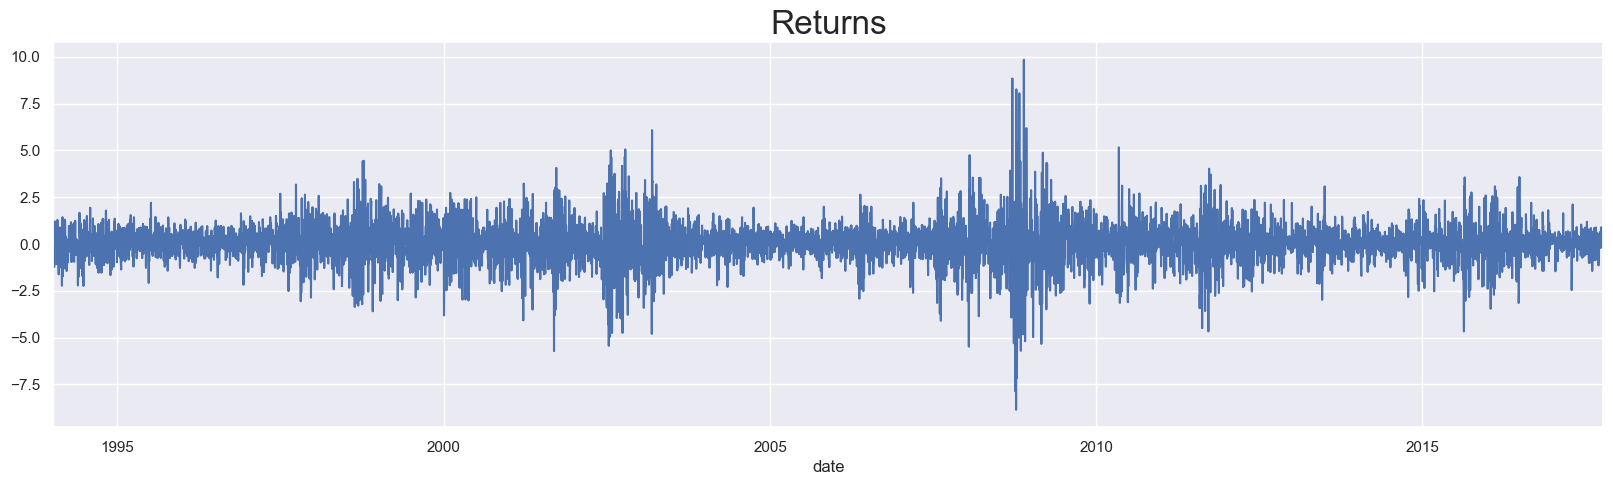

In [10]:
df.returns.plot(figsize=(20,5))
plt.title("Returns", size = 24)
plt.show()

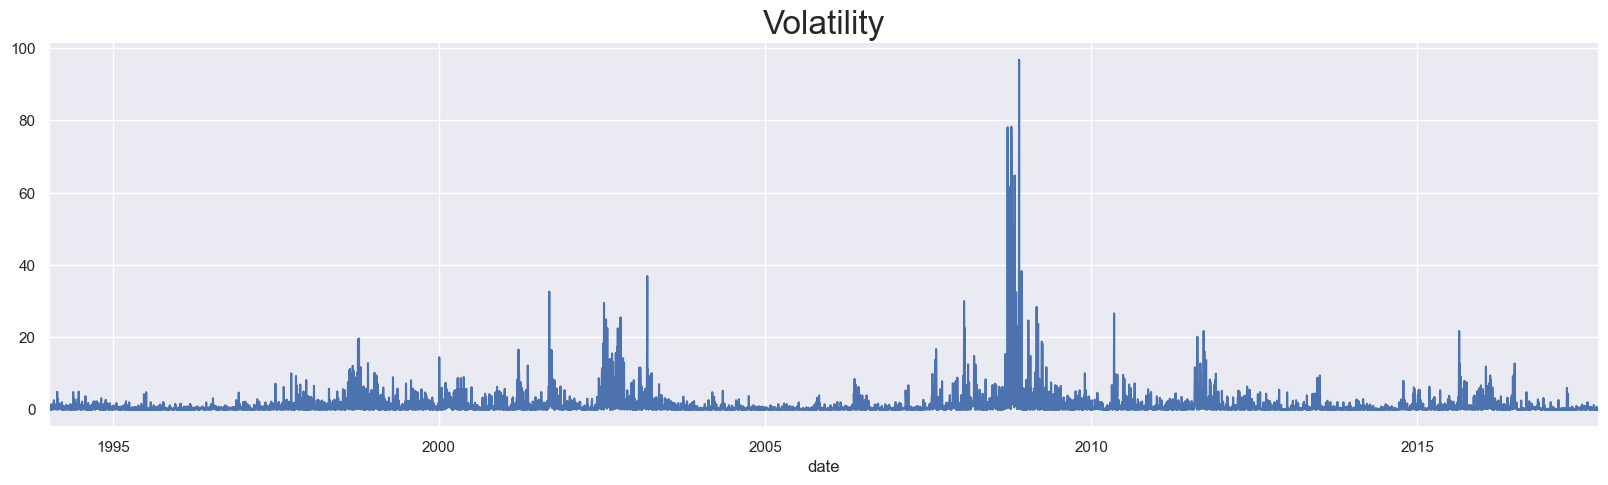

In [11]:
df.sq_returns.plot(figsize=(20,5))
plt.title("Volatility", size = 24)
plt.show()

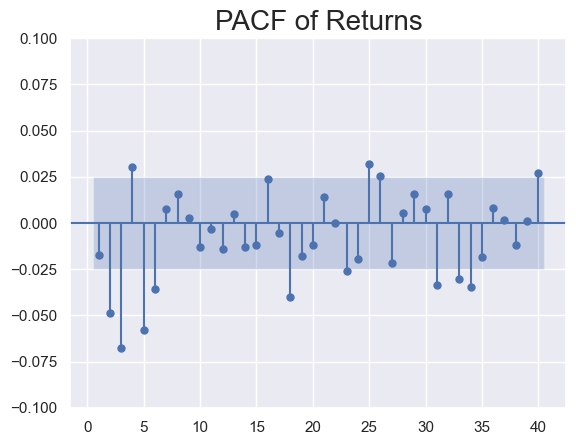

In [15]:
sgt.plot_pacf(df.returns[1:], lags = 40, alpha = 0.05, zero = False , method = ('ols'))
plt.title("PACF of Returns", size = 20)
plt.ylim(-0.1,0.1)
plt.show()

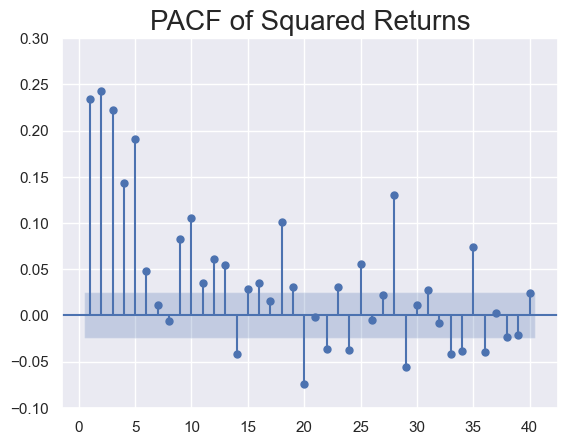

In [19]:
sgt.plot_pacf(df.sq_returns[1:], lags = 40, alpha = 0.05, zero = False , method = ('ols'))
plt.title("PACF of Squared Returns", size = 20)
plt.ylim(-0.1,0.3)
plt.show()

## The arch_model() Method

In [21]:
%pip install arch
from arch import arch_model

     ------------------------------------ 922.8/922.8 kB 261.8 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
model_arch_1 = arch_model(df.returns[1:]) #Modelar la volatilidad condicional en series temporales financieras.
results_arch_1 = model_arch_1.fit(update_freq = 5) #Los resultados se mostrarán cada 5 iteraciones
results_arch_1.summary()

Iteration:      5,   Func. Count:     35,   Neg. LLF: 8364.108387217282
Iteration:     10,   Func. Count:     65,   Neg. LLF: 8357.41125648787
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8357.41125648787
            Iterations: 11
            Function evaluations: 69
            Gradient evaluations: 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8357.41
Distribution:                  Normal   AIC:                           16722.8
Method:            Maximum Likelihood   BIC:                           16749.8
                                        No. Observations:                 6199
Date:                Tue, Oct 10 2023   Df Residuals:                     6198
Time:                        00:27:02   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0431  1.048e-02      4.113  3.909e-05 [2.255e-02,6.361e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0132  3.437e-03      3.839  1.233e-04 [6.460e-03,1.993e-02]
alpha[1]       0.0890  1.149e-02      7.746  9.511e-15   [6.645e-02,  0.111]
beta[1]        0.9002  1.297e-02     69.401      0.000     [  0.875,  0.926]
============================================================================

Covariance estimator: robust
"""

## The Simple ARCH(1) 

In [23]:
#vol = "ARCH" modelo ARCH
#p=1 un rezago (lag) de un período en la varianza condicional
model_arch_1 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 1)
results_arch_1 = model_arch_1.fit(update_freq = 5)
results_arch_1.summary()

Iteration:      5,   Func. Count:     30,   Neg. LLF: 9161.040342649401
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9161.040342649401
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -9161.04
Distribution:                  Normal   AIC:                           18328.1
Method:            Maximum Likelihood   BIC:                           18348.3
                                        No. Observations:                 6199
Date:                Tue, Oct 10 2023   Df Residuals:                     6198
Time:                        00:28:27   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0349  1.382e-02      2.527  1.150e-02 [7.837e-03,6.200e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.8301  3.516e-02     23.611 2.985e-123 [  0.761,  0.899]
alpha[1]       0.3772  4.555e-02      8.282  1.214e-16 [  0.288,  0.467]
========================================================================

Covariance estimator: robust
"""

In [24]:
#lags = [2, 3, 6] los rezagos (lags) a ser incluidos en el modelo ARMA para modelar la media condicional de los retornos
#dist = "ged" Indica que se está utilizando una distribución de errores generalizada 
model_arch_1 = arch_model(df.returns[1:], mean = "AR", lags = [2, 3, 6], vol = "ARCH", p = 1, dist = "ged")
results_arch_1 = model_arch_1.fit(update_freq = 5)
results_arch_1.summary()

Iteration:      5,   Func. Count:     52,   Neg. LLF: 20594.512971969685
Iteration:     10,   Func. Count:    101,   Neg. LLF: 8749.962960258274
Iteration:     15,   Func. Count:    144,   Neg. LLF: 8739.948196899933
Iteration:     20,   Func. Count:    186,   Neg. LLF: 8739.946669452103
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8739.946665392741
            Iterations: 22
            Function evaluations: 203
            Gradient evaluations: 22


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 AR - ARCH Model Results                                  
==========================================================================================
Dep. Variable:                            returns   R-squared:                       0.005
Mean Model:                                    AR   Adj. R-squared:                  0.004
Vol Model:                                   ARCH   Log-Likelihood:               -8739.95
Distribution:      Generalized Error Distribution   AIC:                           17493.9
Method:                        Maximum Likelihood   BIC:                           17541.0
                                                    No. Observations:                 6193
Date:                            Tue, Oct 10 2023   Df Residuals:                     6189
Time:                                    00:31:37   Df Model:                            4
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.0423  2.966e-03     14.252  4.335e-46   [3.646e-02,4.808e-02]
returns[2]    -0.0349  3.085e-02     -1.133      0.257  [-9.541e-02,2.553e-02]
returns[3]    -0.0203  9.926e-03     -2.046  4.074e-02 [-3.977e-02,-8.560e-04]
returns[6]    -0.0156  5.406e-03     -2.879  3.984e-03 [-2.616e-02,-4.971e-03]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.8244  3.064e-02     26.905 1.902e-159 [  0.764,  0.884]
alpha[1]       0.3598  3.612e-02      9.960  2.277e-23 [  0.289,  0.431]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.0602  2.822e-02     37.562 8.848e-309 [  1.005,  1.116]
========================================================================

Covariance estimator: robust
"""

## Higher-Lag ARCH Models

In [25]:
model_arch_2 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 2)
results_arch_2 = model_arch_2.fit(update_freq = 5)
results_arch_2.summary()

Iteration:      5,   Func. Count:     39,   Neg. LLF: 8914.23298295177
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8914.230087754906
            Iterations: 7
            Function evaluations: 49
            Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -8914.23
Distribution:                  Normal   AIC:                           17836.5
Method:            Maximum Likelihood   BIC:                           17863.4
                                        No. Observations:                 6199
Date:                Tue, Oct 10 2023   Df Residuals:                     6198
Time:                        00:33:14   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0424  1.202e-02      3.531  4.135e-04 [1.889e-02,6.600e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6346  2.965e-02     21.404 1.223e-101 [  0.577,  0.693]
alpha[1]       0.2340  3.212e-02      7.283  3.254e-13 [  0.171,  0.297]
alpha[2]       0.2677  3.213e-02      8.332  7.921e-17 [  0.205,  0.331]
========================================================================

Covariance estimator: robust
"""

In [26]:
model_arch_3 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 3)
results_arch_3 = model_arch_3.fit(update_freq = 5)
results_arch_3.summary()

Iteration:      5,   Func. Count:     41,   Neg. LLF: 9253.042580889956
Iteration:     10,   Func. Count:     75,   Neg. LLF: 8700.594521250263
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8700.594521250263
            Iterations: 11
            Function evaluations: 80
            Gradient evaluations: 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -8700.59
Distribution:                  Normal   AIC:                           17411.2
Method:            Maximum Likelihood   BIC:                           17444.8
                                        No. Observations:                 6199
Date:                Tue, Oct 10 2023   Df Residuals:                     6198
Time:                        00:33:34   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0476  1.140e-02      4.178  2.945e-05 [2.527e-02,6.994e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.4626  2.326e-02     19.887  5.285e-88 [  0.417,  0.508]
alpha[1]       0.1645  2.429e-02      6.773  1.257e-11 [  0.117,  0.212]
alpha[2]       0.2066  2.268e-02      9.111  8.198e-20 [  0.162,  0.251]
alpha[3]       0.2769  2.975e-02      9.307  1.310e-20 [  0.219,  0.335]
========================================================================

Covariance estimator: robust
"""

In [27]:
model_arch_13 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 13)
results_arch_13 = model_arch_13.fit(update_freq = 5)
results_arch_13.summary()

Iteration:      5,   Func. Count:     91,   Neg. LLF: 221390.3831276333
Iteration:     10,   Func. Count:    180,   Neg. LLF: 9540.08136200803
Iteration:     15,   Func. Count:    268,   Neg. LLF: 8625.15292268258
Iteration:     20,   Func. Count:    358,   Neg. LLF: 8404.914970945894
Iteration:     25,   Func. Count:    445,   Neg. LLF: 8372.329514623249
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8372.329436084632
            Iterations: 28
            Function evaluations: 492
            Gradient evaluations: 28


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -8372.33
Distribution:                  Normal   AIC:                           16774.7
Method:            Maximum Likelihood   BIC:                           16875.6
                                        No. Observations:                 6199
Date:                Tue, Oct 10 2023   Df Residuals:                     6198
Time:                        00:33:42   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0465  1.059e-02      4.389  1.139e-05 [2.571e-02,6.721e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1915  1.984e-02      9.651  4.854e-22      [  0.153,  0.230]
alpha[1]       0.0705  1.708e-02      4.127  3.676e-05    [3.702e-02,  0.104]
alpha[2]       0.1087  1.795e-02      6.052  1.429e-09    [7.347e-02,  0.144]
alpha[3]       0.1320  2.296e-02      5.750  8.945e-09    [8.700e-02,  0.177]
alpha[4]       0.0899  1.838e-02      4.889  1.012e-06    [5.385e-02,  0.126]
alpha[5]       0.0700  1.639e-02      4.269  1.963e-05    [3.784e-02,  0.102]
alpha[6]       0.0793  1.660e-02      4.776  1.786e-06    [4.676e-02,  0.112]
alpha[7]       0.0411  1.716e-02      2.393  1.671e-02  [7.430e-03,7.469e-02]
alpha[8]       0.0640  1.635e-02      3.915  9.022e-05  [3.197e-02,9.605e-02]
alpha[9]       0.0275  1.450e-02      1.894  5.822e-02 [-9.561e-04,5.587e-02]
alpha[10]      0.0295  1.444e-02      2.044  4.100e-02  [1.207e-03,5.781e-02]
alpha[11]      0.0661  1.622e-02      4.078  4.548e-05  [3.435e-02,9.793e-02]
alpha[12]      0.0494  1.627e-02      3.035  2.406e-03  [1.749e-02,8.129e-02]
alpha[13]      0.0225  1.219e-02      1.842  6.543e-02 [-1.435e-03,4.636e-02]
=============================================================================

Covariance estimator: robust
"""